In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load from cleaned file or re-create from grouped global data
df = pd.read_csv('/content/drive/MyDrive/Climate/Data/owid-co2-data.csv')
df = df[~df['country'].isin(['World', 'Africa', 'Asia', 'Europe', 'European Union',
                             'North America', 'South America', 'Oceania', 'Antarctica', 'International transport'])]
df = df.dropna(subset=['co2'])
df_global = df.groupby('year')['co2'].sum().reset_index()


In [2]:

pip install prophet


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxv9e31h0/_ahlxeno.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxv9e31h0/i2rdkvbp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39288', 'data', 'file=/tmp/tmpxv9e31h0/_ahlxeno.json', 'init=/tmp/tmpxv9e31h0/i2rdkvbp.json', 'output', 'file=/tmp/tmpxv9e31h0/prophet_modeli1b39wly/prophet_model-20250418061524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:15:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

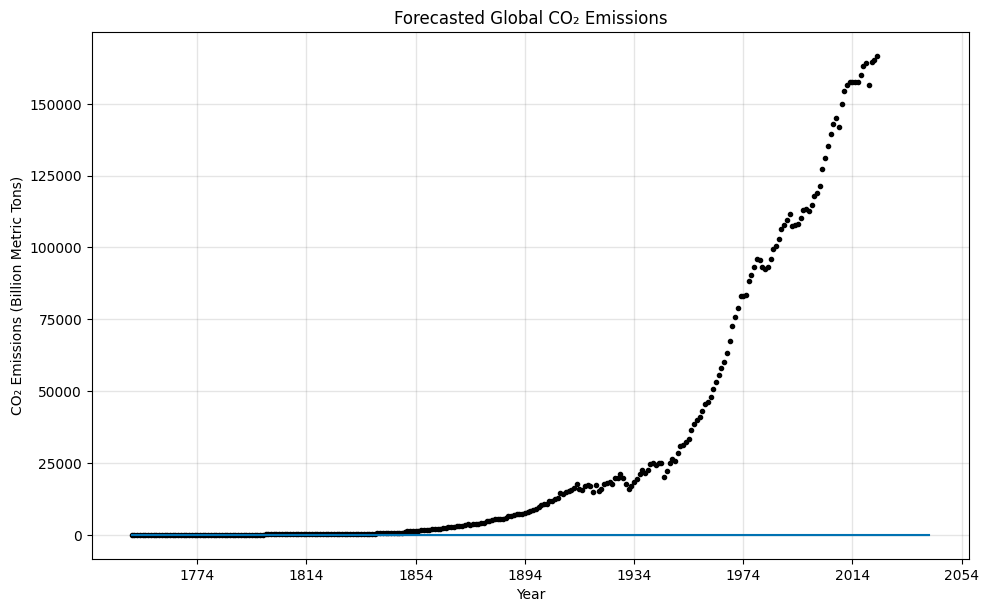

In [3]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Regroup (in case this is a fresh notebook)
df_global = df.groupby('year')['co2'].sum().reset_index()

# Fix: Convert to datetime
df_prophet = df_global.rename(columns={"year": "ds", "co2": "y"})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

#  Remove any infinite or missing values
df_prophet = df_prophet.replace([float('inf'), float('-inf')], pd.NA)
df_prophet = df_prophet.dropna(subset=['ds', 'y'])

# Prophet Model
model = Prophet()
model.fit(df_prophet)

# Forecast next 30 years
future = model.make_future_dataframe(periods=19, freq='Y')
forecast = model.predict(future)

# Scale the forecast to billions for display purpose
forecast['yhat'] = forecast['yhat'] / 1_000_000  # Billion metric tons
forecast['yhat_lower'] = forecast['yhat_lower'] / 1_000_000  # Billion metric tons
forecast['yhat_upper'] = forecast['yhat_upper'] / 1_000_000  # Billion metric tons

# Plot
fig = model.plot(forecast)
plt.title("Forecasted Global CO₂ Emissions")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions (Billion Metric Tons)")
plt.show()

In [4]:
# Make sure you know the last year in your data
last_year = df_prophet['ds'].dt.year.max()
future_years = 30
target_year = last_year + future_years

# Create a future DataFrame with 30 more years
future = model.make_future_dataframe(periods=future_years, freq='Y')

# Sanity check: see how far it goes
print(future.tail())


            ds
299 2048-12-31
300 2049-12-31
301 2050-12-31
302 2051-12-31
303 2052-12-31


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [5]:
df_prophet = df_prophet.replace([float('inf'), float('-inf')], pd.NA)
df_prophet = df_prophet.dropna(subset=['ds', 'y'])
df_prophet['y'] = df_prophet['y'].astype('float64')


In [6]:
pip install statsmodels


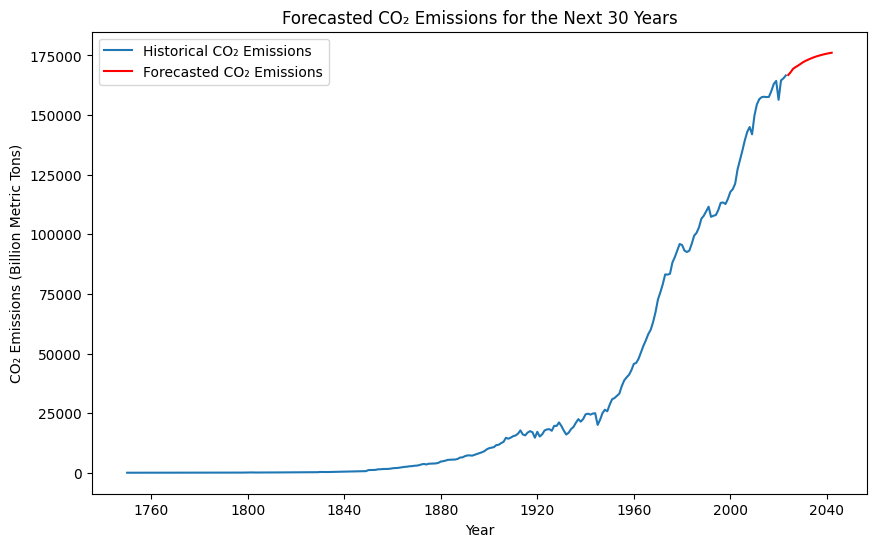

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Prepare your data for ARIMA
df_global = df.groupby('year')['co2'].sum().reset_index()
df_prophet = df_global.rename(columns={"year": "ds", "co2": "y"})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

# Use ARIMA for time series forecasting
model = ARIMA(df_prophet['y'], order=(5, 1, 0))  # You can tweak the order
model_fit = model.fit()

# Forecasting 30 years into the future
forecast = model_fit.forecast(steps=19)

# Plotting the forecasted CO2 emissions
last_year = df_prophet['ds'].max().year
years_future = pd.to_datetime([f"{last_year + i}-01-01" for i in range(1, 20)])

plt.figure(figsize=(10, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label="Historical CO₂ Emissions")
plt.plot(years_future, forecast, label="Forecasted CO₂ Emissions", color='red')
plt.title("Forecasted CO₂ Emissions for the Next 30 Years")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions (Billion Metric Tons)")
plt.legend()
plt.show()
